# MLP

First MLP after revising our data in Oct 2022. Before, we were using sequences from Ensembl files. Now, we are using sequences from GenCode files. 

## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-11-03 11:18:48.315968
Python 3.10.0
sklearn 1.1.2


In [2]:
import tensorflow as tf
dt = np.float32
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 
#from sklearn.model_selection import ShuffleSplit
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import RepeatedKFold
#from sklearn.model_selection import StratifiedKFold
#import tensorflow as tf
#from tensorflow import keras
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
#from keras.layers import Bidirectional
from keras.layers import Dense
#from keras.layers import LayerNormalization
#from sklearn.preprocessing import StandardScaler
from keras.losses import BinaryCrossentropy
from sklearn.model_selection import KFold

from KmerCounter import KmerCounter
ALPHABET_SIZE=4
K=4
counter=KmerCounter(K)
VOCABULARY_SIZE = counter.get_vocabulary_size() 
print('K=',K,'alphabet size=',ALPHABET_SIZE,'vocabulary size=',VOCABULARY_SIZE)
from TrainValidSplit2 import Splitter2
EPOCHS=10
FOLDS=5
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

K= 4 alphabet size= 4 vocabulary size= 256


In [3]:
DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'
GENES_FILE = 'CNRCI_coding_train_genes.csv'
RCI_FILE = 'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE='CNRCI_coding_train_counts.K4.gc42.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    # Here is the joke model -- one neuron!
    mlp       = Sequential()
    one_layer = Dense(1, activation='sigmoid',dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    mlp.add(one_layer)
      
    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [6]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-11-03 11:19:00.589872
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


2022-11-03 11:19:00.597111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data

In [7]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-11-03 11:19:00.739133
Num RCI: 10338
[('ENSG00000000003', 1.08068), ('ENSG00000000419', 1.32679), ('ENSG00000000457', 0.434284)]


In [8]:
# kmer counts
filepath = DATA_DIR+COUNTS_FILE
labels=[]
allids=[]
counts=[]
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            gene_id = fields.pop(0)
            tran_id = fields.pop(0)
            numbers = [int(x) for x in fields]
            if gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                counts.append(numbers)
print(datetime.now())
print('Num IDs:',len(allids))
print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(counts))
print('Example:',counts[3])

2022-11-03 11:19:05.526113
Num IDs: 54251
Examples: [('ENSG00000187634', 'ENST00000455979.1'), ('ENSG00000187608', 'ENST00000624652.1'), ('ENSG00000131591', 'ENST00000427787.5'), ('ENSG00000160087', 'ENST00000360466.6')]
Num labels: 54251
Examples: [-1.20021, -0.0182098, -1.98467, -0.297418]
Num counts: 54251
Example: [9, 2, 7, 6, 5, 6, 1, 4, 14, 10, 10, 3, 4, 2, 4, 3, 6, 7, 6, 3, 8, 14, 7, 13, 6, 2, 15, 8, 0, 8, 10, 6, 9, 10, 19, 7, 17, 24, 15, 20, 22, 15, 26, 7, 1, 5, 4, 1, 3, 1, 0, 2, 4, 8, 2, 5, 4, 5, 11, 3, 1, 1, 1, 3, 8, 5, 10, 1, 13, 19, 9, 9, 14, 45, 26, 2, 1, 6, 6, 1, 9, 31, 31, 3, 32, 60, 24, 29, 12, 19, 22, 7, 2, 21, 39, 10, 4, 9, 15, 4, 4, 25, 10, 5, 16, 24, 18, 7, 2, 11, 5, 3, 0, 5, 1, 1, 11, 19, 9, 12, 13, 42, 29, 10, 2, 16, 7, 7, 4, 9, 20, 5, 3, 15, 18, 9, 17, 21, 31, 6, 1, 7, 9, 1, 3, 8, 34, 4, 21, 52, 21, 19, 12, 17, 17, 4, 2, 13, 33, 12, 14, 17, 34, 6, 15, 39, 18, 23, 20, 37, 41, 10, 2, 12, 15, 2, 0, 1, 2, 2, 7, 13, 5, 8, 8, 6, 16, 2, 1, 2, 4, 3, 3, 0, 0, 1, 1, 2, 3, 

In [9]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    return subsetX,subsetY

## Train and validate with all K-mer counts

In [10]:
SCALING = False
def do_cross_validation(eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,counts,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,counts,labels,0)
        print(X_train[0])
        print(len(X_train[0]))
        print(y_train[:3])
        #train_genes,valid_genes = one_partition[0],one_partition[1]
        #thresholdsT = splitter.choose_thresholds(train_genes,'one_z')
        #X_train,y_train,train_ids = splitter.get_X_y(train_genes, thresholdsT)
        #thresholdsV = splitter.choose_thresholds(train_genes,'mean')
        #X_valid,y_valid,valid_ids = splitter.get_X_y(valid_genes, thresholdsV)

        if SCALING:
            print('scaling')
            print(datetime.now())
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_valid = scaler.transform(X_valid)

        fold += 1
        print('Fold',fold)
        print('Train sizes',len(X_train),len(y_train))
        print('Valid sizes',len(X_valid),len(y_valid))
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
    print()
    print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


2022-11-03 11:19:05.633446
2022-11-03 11:19:05.633682
splitting
[9, 3, 8, 6, 5, 7, 3, 7, 15, 10, 14, 4, 5, 2, 4, 3, 8, 7, 6, 3, 8, 17, 11, 17, 10, 6, 16, 10, 1, 13, 15, 6, 10, 12, 20, 6, 19, 29, 19, 21, 24, 23, 29, 8, 1, 8, 7, 5, 4, 1, 1, 2, 3, 9, 4, 5, 3, 6, 11, 4, 1, 1, 1, 4, 10, 9, 14, 1, 14, 23, 12, 11, 13, 50, 30, 5, 1, 8, 7, 1, 14, 37, 38, 6, 33, 76, 45, 31, 14, 49, 45, 9, 3, 28, 46, 10, 4, 13, 26, 6, 8, 47, 31, 17, 22, 53, 39, 8, 3, 13, 9, 3, 0, 8, 2, 1, 12, 29, 16, 17, 15, 58, 41, 10, 2, 17, 8, 7, 4, 10, 20, 6, 4, 19, 22, 15, 20, 26, 36, 12, 2, 7, 9, 2, 5, 12, 36, 5, 33, 71, 46, 27, 19, 41, 46, 6, 3, 21, 47, 14, 15, 25, 41, 8, 16, 65, 51, 31, 25, 57, 52, 12, 2, 14, 17, 3, 0, 1, 3, 2, 9, 16, 6, 10, 7, 10, 22, 2, 2, 5, 5, 3, 3, 0, 1, 1, 1, 4, 5, 2, 0, 2, 4, 0, 0, 4, 4, 1, 7, 4, 18, 3, 21, 21, 15, 12, 6, 7, 15, 3, 4, 12, 17, 4, 11, 10, 7, 0, 15, 36, 11, 16, 18, 29, 26, 8, 0, 6, 8, 4, 1, 2, 0, 4, 8, 15, 5, 5, 3, 4, 7, 2, 2, 10, 2, 5]
256
[0, 0, 0]
Fold 1
Train sizes 43592 43592
Val

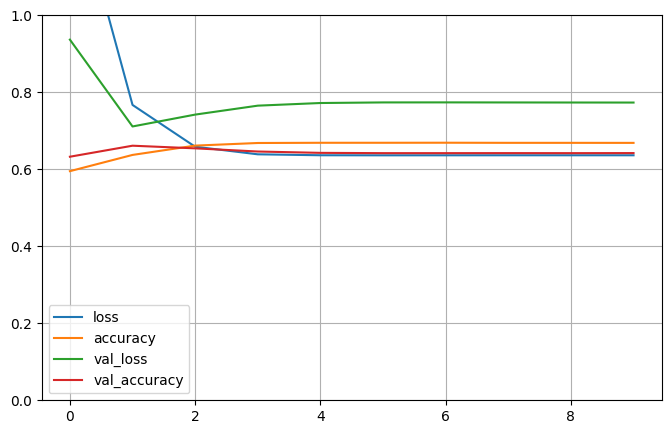

Compute valiation accuracy
2022-11-03 11:20:33.457502
accuracy: 64.21%
2022-11-03 11:20:45.328978
[9, 3, 8, 6, 5, 7, 3, 7, 15, 10, 14, 4, 5, 2, 4, 3, 8, 7, 6, 3, 8, 17, 11, 17, 10, 6, 16, 10, 1, 13, 15, 6, 10, 12, 20, 6, 19, 29, 19, 21, 24, 23, 29, 8, 1, 8, 7, 5, 4, 1, 1, 2, 3, 9, 4, 5, 3, 6, 11, 4, 1, 1, 1, 4, 10, 9, 14, 1, 14, 23, 12, 11, 13, 50, 30, 5, 1, 8, 7, 1, 14, 37, 38, 6, 33, 76, 45, 31, 14, 49, 45, 9, 3, 28, 46, 10, 4, 13, 26, 6, 8, 47, 31, 17, 22, 53, 39, 8, 3, 13, 9, 3, 0, 8, 2, 1, 12, 29, 16, 17, 15, 58, 41, 10, 2, 17, 8, 7, 4, 10, 20, 6, 4, 19, 22, 15, 20, 26, 36, 12, 2, 7, 9, 2, 5, 12, 36, 5, 33, 71, 46, 27, 19, 41, 46, 6, 3, 21, 47, 14, 15, 25, 41, 8, 16, 65, 51, 31, 25, 57, 52, 12, 2, 14, 17, 3, 0, 1, 3, 2, 9, 16, 6, 10, 7, 10, 22, 2, 2, 5, 5, 3, 3, 0, 1, 1, 1, 4, 5, 2, 0, 2, 4, 0, 0, 4, 4, 1, 7, 4, 18, 3, 21, 21, 15, 12, 6, 7, 15, 3, 4, 12, 17, 4, 11, 10, 7, 0, 15, 36, 11, 16, 18, 29, 26, 8, 0, 6, 8, 4, 1, 2, 0, 4, 8, 15, 5, 5, 3, 4, 7, 2, 2, 10, 2, 5]
256
[0, 0, 0]


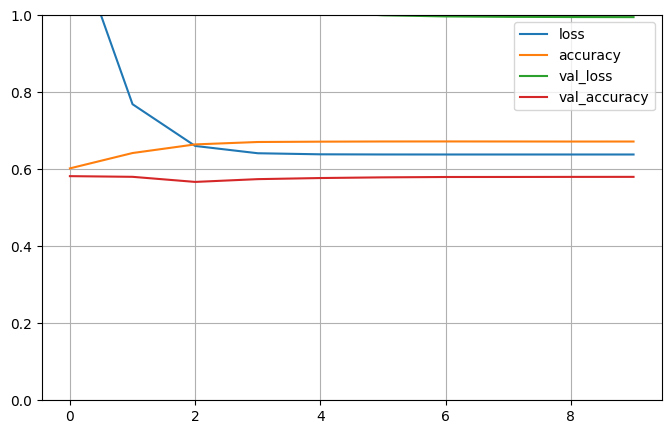

Compute valiation accuracy
2022-11-03 11:22:13.610814
accuracy: 58.03%
2022-11-03 11:22:25.050495
[9, 3, 8, 6, 5, 7, 3, 7, 15, 10, 14, 4, 5, 2, 4, 3, 8, 7, 6, 3, 8, 17, 11, 17, 10, 6, 16, 10, 1, 13, 15, 6, 10, 12, 20, 6, 19, 29, 19, 21, 24, 23, 29, 8, 1, 8, 7, 5, 4, 1, 1, 2, 3, 9, 4, 5, 3, 6, 11, 4, 1, 1, 1, 4, 10, 9, 14, 1, 14, 23, 12, 11, 13, 50, 30, 5, 1, 8, 7, 1, 14, 37, 38, 6, 33, 76, 45, 31, 14, 49, 45, 9, 3, 28, 46, 10, 4, 13, 26, 6, 8, 47, 31, 17, 22, 53, 39, 8, 3, 13, 9, 3, 0, 8, 2, 1, 12, 29, 16, 17, 15, 58, 41, 10, 2, 17, 8, 7, 4, 10, 20, 6, 4, 19, 22, 15, 20, 26, 36, 12, 2, 7, 9, 2, 5, 12, 36, 5, 33, 71, 46, 27, 19, 41, 46, 6, 3, 21, 47, 14, 15, 25, 41, 8, 16, 65, 51, 31, 25, 57, 52, 12, 2, 14, 17, 3, 0, 1, 3, 2, 9, 16, 6, 10, 7, 10, 22, 2, 2, 5, 5, 3, 3, 0, 1, 1, 1, 4, 5, 2, 0, 2, 4, 0, 0, 4, 4, 1, 7, 4, 18, 3, 21, 21, 15, 12, 6, 7, 15, 3, 4, 12, 17, 4, 11, 10, 7, 0, 15, 36, 11, 16, 18, 29, 26, 8, 0, 6, 8, 4, 1, 2, 0, 4, 8, 15, 5, 5, 3, 4, 7, 2, 2, 10, 2, 5]
256
[0, 0, 0]


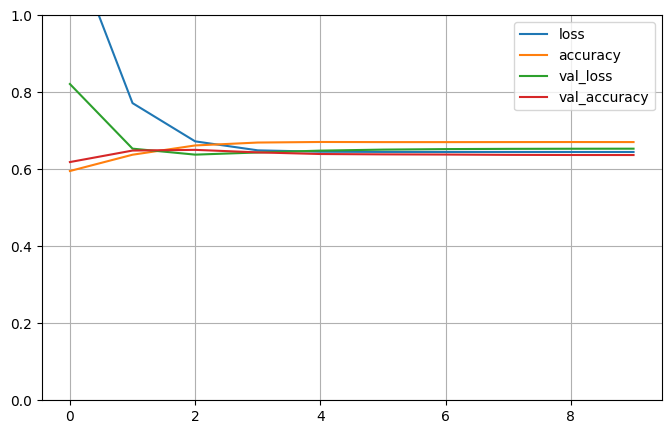

Compute valiation accuracy
2022-11-03 11:23:49.355003
accuracy: 63.70%
2022-11-03 11:24:01.116834
[9, 3, 8, 6, 5, 7, 3, 7, 15, 10, 14, 4, 5, 2, 4, 3, 8, 7, 6, 3, 8, 17, 11, 17, 10, 6, 16, 10, 1, 13, 15, 6, 10, 12, 20, 6, 19, 29, 19, 21, 24, 23, 29, 8, 1, 8, 7, 5, 4, 1, 1, 2, 3, 9, 4, 5, 3, 6, 11, 4, 1, 1, 1, 4, 10, 9, 14, 1, 14, 23, 12, 11, 13, 50, 30, 5, 1, 8, 7, 1, 14, 37, 38, 6, 33, 76, 45, 31, 14, 49, 45, 9, 3, 28, 46, 10, 4, 13, 26, 6, 8, 47, 31, 17, 22, 53, 39, 8, 3, 13, 9, 3, 0, 8, 2, 1, 12, 29, 16, 17, 15, 58, 41, 10, 2, 17, 8, 7, 4, 10, 20, 6, 4, 19, 22, 15, 20, 26, 36, 12, 2, 7, 9, 2, 5, 12, 36, 5, 33, 71, 46, 27, 19, 41, 46, 6, 3, 21, 47, 14, 15, 25, 41, 8, 16, 65, 51, 31, 25, 57, 52, 12, 2, 14, 17, 3, 0, 1, 3, 2, 9, 16, 6, 10, 7, 10, 22, 2, 2, 5, 5, 3, 3, 0, 1, 1, 1, 4, 5, 2, 0, 2, 4, 0, 0, 4, 4, 1, 7, 4, 18, 3, 21, 21, 15, 12, 6, 7, 15, 3, 4, 12, 17, 4, 11, 10, 7, 0, 15, 36, 11, 16, 18, 29, 26, 8, 0, 6, 8, 4, 1, 2, 0, 4, 8, 15, 5, 5, 3, 4, 7, 2, 2, 10, 2, 5]
256
[0, 0, 0]


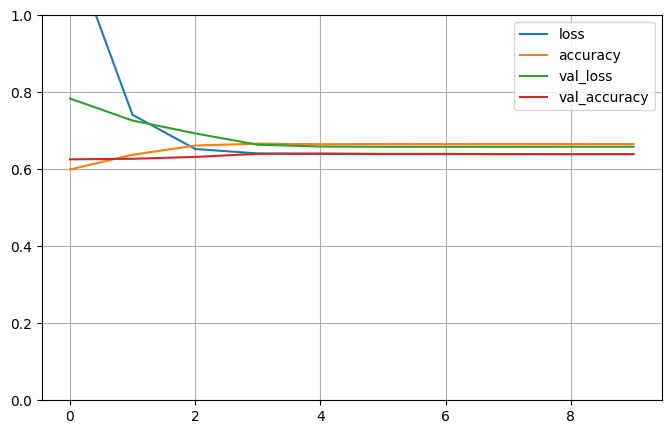

Compute valiation accuracy
2022-11-03 11:25:25.710149
accuracy: 63.95%
2022-11-03 11:25:37.304986
[3, 5, 12, 6, 4, 2, 4, 8, 20, 22, 14, 9, 1, 1, 6, 6, 6, 7, 15, 7, 11, 9, 6, 17, 9, 6, 7, 3, 2, 9, 12, 5, 12, 15, 22, 8, 27, 19, 7, 32, 34, 21, 14, 6, 3, 14, 10, 7, 2, 5, 1, 0, 10, 9, 3, 4, 7, 5, 10, 6, 1, 5, 3, 6, 9, 9, 16, 3, 8, 11, 6, 13, 14, 39, 23, 15, 4, 17, 9, 5, 9, 11, 27, 9, 12, 18, 10, 20, 11, 9, 16, 9, 3, 18, 36, 16, 7, 6, 13, 1, 7, 10, 2, 4, 13, 14, 20, 4, 5, 8, 7, 3, 1, 7, 2, 0, 8, 14, 14, 16, 26, 43, 35, 17, 1, 19, 6, 10, 9, 4, 36, 5, 14, 22, 14, 4, 21, 22, 37, 10, 3, 6, 10, 1, 13, 13, 37, 10, 17, 22, 16, 17, 5, 4, 13, 7, 1, 15, 53, 11, 21, 18, 41, 9, 16, 25, 13, 23, 24, 19, 26, 6, 1, 6, 20, 5, 1, 7, 2, 5, 8, 13, 4, 10, 6, 18, 18, 9, 1, 13, 5, 5, 5, 0, 1, 0, 9, 8, 1, 3, 2, 2, 1, 0, 0, 2, 3, 3, 9, 7, 12, 9, 16, 11, 13, 19, 2, 4, 15, 4, 4, 10, 20, 4, 14, 15, 14, 2, 23, 18, 7, 20, 18, 23, 15, 16, 6, 7, 14, 9, 2, 2, 0, 3, 11, 23, 4, 8, 7, 2, 9, 4, 4, 9, 8, 8]
256
[0, 0, 0]
Fold 5


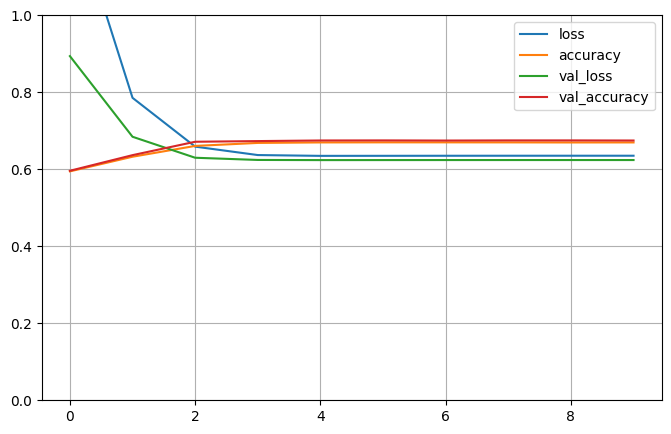

Compute valiation accuracy
2022-11-03 11:27:05.398552
accuracy: 67.47%
2022-11-03 11:27:16.964590

Cross validation acc mean 63.47% (+/- 3.05%)
2022-11-03 11:27:16.976096


In [11]:
print(datetime.now())
do_cross_validation(EPOCHS)    
print(datetime.now())